In [2]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)



Toggle code

# Plot Maps


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background') # dark background style for figure

import iris
import iris.plot as iplt
import iris.quickplot as qplt

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.ticker as mticker

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

### Load location of EEL stations

In [4]:
pathdir = '../data/raw/csv_ctdgrid'

file3 = pathdir+'/'+'EELCTDandLADCP_refpos.csv'

dfloc = pd.read_csv(file3,sep=',', index_col=None, 
                     header=0)
# Make sure the station name are sorted by their distance along the section
sdfloc = dfloc.sort_values('Refdist', ascending=True)
print(sdfloc)

   Staname      Refdist  LonSta  LatSta  DepthSta
68   IB23S     0.000000 -20.215  63.317       120
67   IB22S    13.442044 -20.067  63.216       670
66   IB21S    25.375111 -19.916  63.133      1030
65   IB20S    55.616831 -19.551  62.917      1400
64   IB19S    84.025700 -19.668  62.667      1670
..     ...          ...     ...     ...       ...
4       5G  1277.489387  -6.600  56.733        80
3       4G  1286.632474  -6.450  56.733       115
2       3G  1292.405649  -6.367  56.708        70
1       2G  1298.235343  -6.283  56.683        30
0       1G  1307.563533  -6.133  56.667       190

[69 rows x 5 columns]


<br><br>
## Plot North Atlantic Map with location of EEL stations

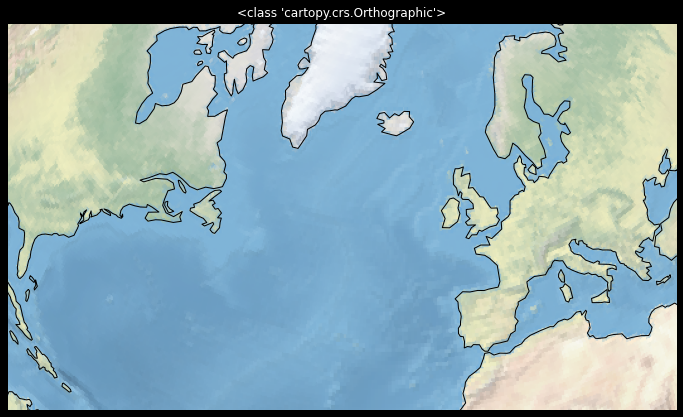

In [5]:
#proj = ccrs.Robinson(-20)
proj = ccrs.Orthographic(-20, 50)

plt.figure(figsize=(12, 12))
ax = plt.axes(projection=proj)
ax.stock_img()
ax.coastlines()
ax.set_title(f'{type(proj)}')
ax.set_extent([-80, 20, 20, 70])

<br><br>
#### Plot a topography map using the etopo1 data from the NOAA opendap server. With iris we can slice the data before downloading it. Finally we will "print" our cube to check the metadata.

In [6]:
# Definition variables for maps
central_lon, central_lat = -10, 45
extent_extract = [-30, 10, 50, 70]
extent_map = [-26, 0, 51, 66]

In [7]:
def get_cube(url):
    coord_values = {'latitude':lambda cell: extent_extract[2] <= cell <= extent_extract[3],
                    'longitude': lambda cell: extent_extract[0] <= cell <= extent_extract[1]}
    constraint = iris.Constraint(coord_values=coord_values)
    bathy = iris.load_cube(url, constraint)
    return bathy

# try:
#     bathy = get_cube('/Users/locupe/Dropbox/Work/function_MATLAB/bathymetrie/bathy_gebco.nc')
# except:
#     bathy = get_cube('http://thredds.aoos.org/thredds/dodsC/GEBCO2014_NORTHERN_HEM.nc')

bathy = get_cube('http://thredds.aoos.org/thredds/dodsC/GEBCO2014_NORTHERN_HEM.nc') 
bathy = iris.util.squeeze(bathy)



print(bathy)

/Users/locupe/anaconda2/envs/analysis_eel_data/lib/python3.8/site-packages/iris/fileformats/cf.py:324: UserWarning: Missing CF-netCDF auxiliary coordinate variable 'y', referenced by netCDF variable 'elevation'
  warnings.warn(message % (name, nc_var_name))
/Users/locupe/anaconda2/envs/analysis_eel_data/lib/python3.8/site-packages/iris/fileformats/cf.py:324: UserWarning: Missing CF-netCDF auxiliary coordinate variable 'x', referenced by netCDF variable 'elevation'
  warnings.warn(message % (name, nc_var_name))
/Users/locupe/anaconda2/envs/analysis_eel_data/lib/python3.8/site-packages/iris/fileformats/cf.py:649: UserWarning: Missing CF-netCDF label variable 'y', referenced by netCDF variable 'elevation'
  warnings.warn(message % (name, nc_var_name))
/Users/locupe/anaconda2/envs/analysis_eel_data/lib/python3.8/site-packages/iris/fileformats/cf.py:649: UserWarning: Missing CF-netCDF label variable 'x', referenced by netCDF variable 'elevation'
  warnings.warn(message % (name, nc_var_name)

height_above_reference_ellipsoid / (m) (latitude: 2400; longitude: 4800)
     Dimension coordinates:
          latitude                              x                -
          longitude                             -                x
     Scalar coordinates:
          time: 2014-12-03 00:00:00
     Attributes:
          Conventions: CF-1.0
          History: Translated to CF-1.0 Conventions by Netcdf-Java CDM (NetcdfCFWriter)
Original...
          NCO: 4.4.8
          comment: The data in the GEBCO_2014 Grid should not be used for navigation or any...
          history: Tue May  5 08:08:12 2015: ncpdq -O -a lat,lon GEBCO_2014_2D_-180.0_0.0_180.0_90.0_lon.nc...
          institution: On behalf of the General Bathymetric Chart of the Oceans (GEBCO), the data...
          nco_openmp_thread_number: 1
          node_offset: 1
          references: Information on the data set is available from the GEBCO project web pages:...
          sdn_parameter_name: Sea floor height (above mean sea lev

<br><br>
### Plot the regional bathymetry map

In [8]:
import palettable

from palettable import colorbrewer
from palettable.cmocean.sequential import Ice_12 as ocean

plt.rcParams.update({'font.size': 14})

\
Define specific function to plot map

In [9]:
# Define a function to plot the background map
def plot_bathy_ENA(fig=False,ax=False,limits='default',gridlines=True,colorbar=True):
    """ Function to plot the map of the Eastern North Atlantic with the associated bathymetry

    plot_bathy_ENA(fig=False,ax=False,limits='default',gridlines=True,colorbar=True)
    
    Returns:
    (fig, ax, cplot): Figure, axes and contourf objects generated by plt.subplots

    """
    
    land = colorbrewer.get_map('Accent', 'qualitative', 8)
    #ocean = colorbrewer.get_map('Blues', 'sequential', 6, reverse=True)
    colors = np.array(ocean.mpl_colors[-6:])

    levels = [-3000, -2000, -1250, -1000, -650, -200, 0]

    #titlefig = 'Map Eastern North Atlantic'
    if not fig:
        fig, ax = plt.subplots(figsize=(12, 12),
                               subplot_kw=dict(projection=ccrs.Mercator(central_lon, central_lat)))
    else:
        plt.axes(ax)
    
    cplot = iris.plot.contourf(bathy, levels, colors=colors, extend='both')
    cplot.cmap.set_under(ocean.mpl_colors[-7])
    cplot.cmap.set_over(land.mpl_colors[-1])

    # Set the colormap limits
    plt.clim([np.min(levels),np.max(levels)])
    
    if colorbar:
        cbar = plt.colorbar(cplot, ax=ax, orientation="vertical", pad=.05, aspect=40)  
        cbar.ax.set_ylabel('Depth (m)')
        
    if limits=='default':
        ax.set_extent([-28.1, 0.1, 51, 66])
    else:
        ax.set_extent(limits)       
        
    ax.coastlines('10m', color='k')

    if (limits=='default') & gridlines:
        gl = ax.gridlines(crs=ccrs.PlateCarree(), ylocs=np.arange(52,68,2),
                          draw_labels=True, linewidth=1, color='gray', alpha=0.8, linestyle='-.')

        gl.xlabels_top = False
        gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
    
    return (fig, ax, cplot)

\
Define specific function to plot specific gridlines on a map

In [10]:
# Define a function to plot grid axis on map
def plot_gridlines(ax,xtick,ytick):
    """ Function to plot gridline on a map generated by cartopy (on a PlateCarree projection)

    plot_gridlines(ax,xtick,ytick)
    
    Returns:
    gl: gridline object

    """
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
                       linewidth=1, color='gray', alpha=0.8, linestyle='-.')
    gl.ylocator = mticker.FixedLocator(ytick)
    gl.xlocator = mticker.FixedLocator(xtick)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
 
    
    return gl

In [11]:
plot_bathy_ENA?

Signature:
plot_bathy_ENA(
    fig=False,
    ax=False,
    limits='default',
    gridlines=True,
    colorbar=True,
)
Docstring:
Function to plot the map of the Eastern North Atlantic with the associated bathymetry

plot_bathy_ENA(fig=False,ax=False,limits='default',gridlines=True,colorbar=True)

Returns:
(fig, ax, cplot): Figure, axes and contourf objects generated by plt.subplots
File:      ~/Dropbox/Work/Python/Repos_perso/analysis_eel_data/notebooks/<ipython-input-9-a02d7c94c44a>
Type:      function


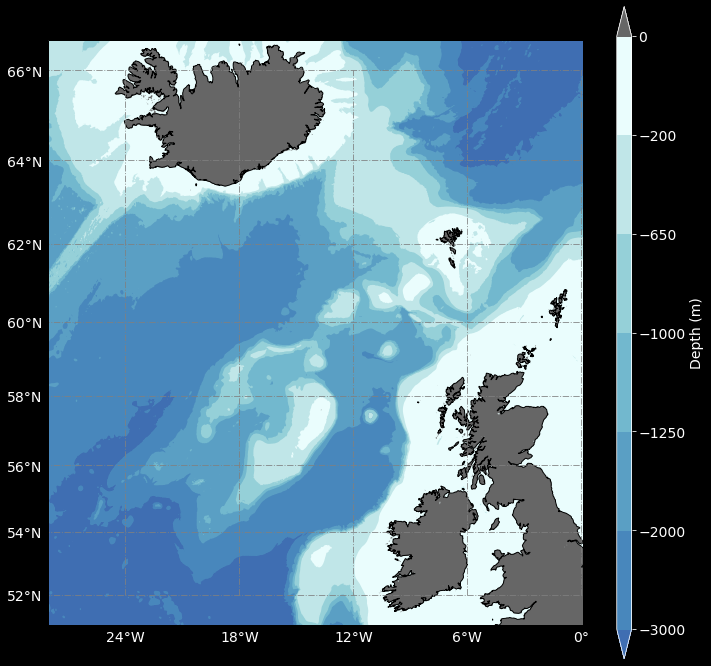

In [12]:
# plot map
(fig,ax,cplot)=plot_bathy_ENA()
fig.savefig('figures/'+'01_Map_Eastern_NA.pdf')     

<br><br>
#### Add the reference stations of the EEL section 

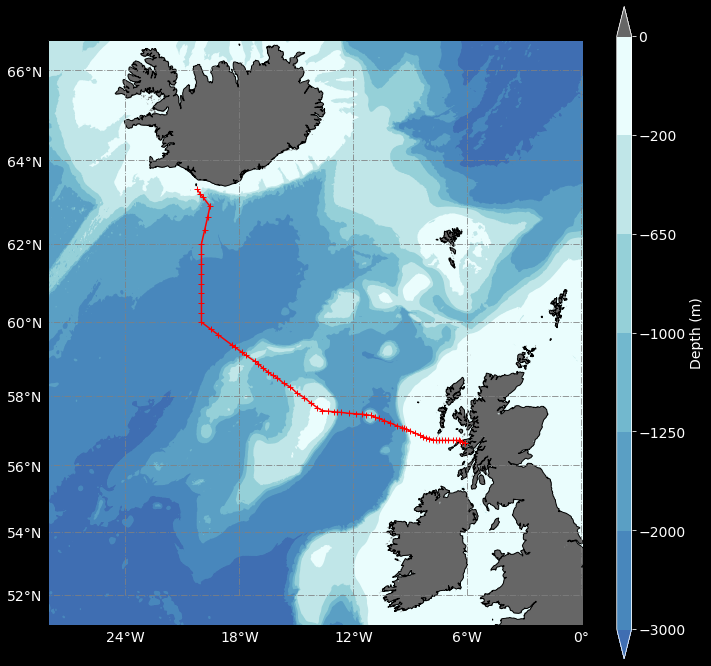

In [13]:
ax.plot(sdfloc['LonSta'], sdfloc['LatSta'],
         color='red', linestyle='-', marker='+', transform=ccrs.PlateCarree())
fig.savefig('figures/'+'01_Map_Eastern_NA_withEELsec.pdf')   
fig

<br><br>
#### Plot regional zoom with station labels

Plot Map for Rockall Trough area

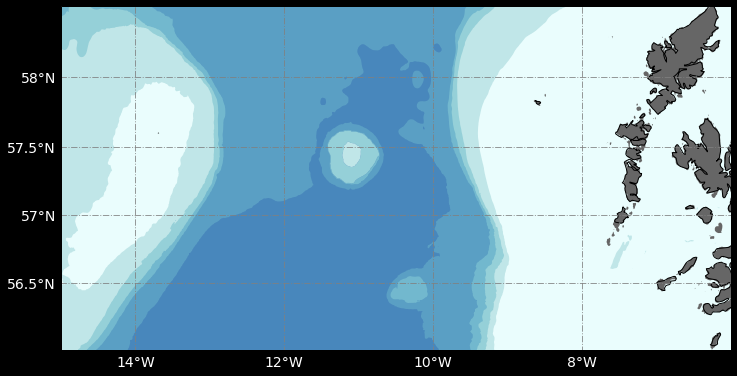

In [14]:
(fig,axRT,cplot)=plot_bathy_ENA(limits=[-15, -6, 56, 58.5],colorbar=False)
plot_gridlines(axRT,np.arange(-20,-2,2),np.arange(55.5,59.5,0.5))

\
Add EEL stations

In [15]:
axRT.plot(sdfloc['LonSta'], sdfloc['LatSta'],
         color='red', linestyle='-', marker='+', transform=ccrs.PlateCarree());

\
Add colorbar

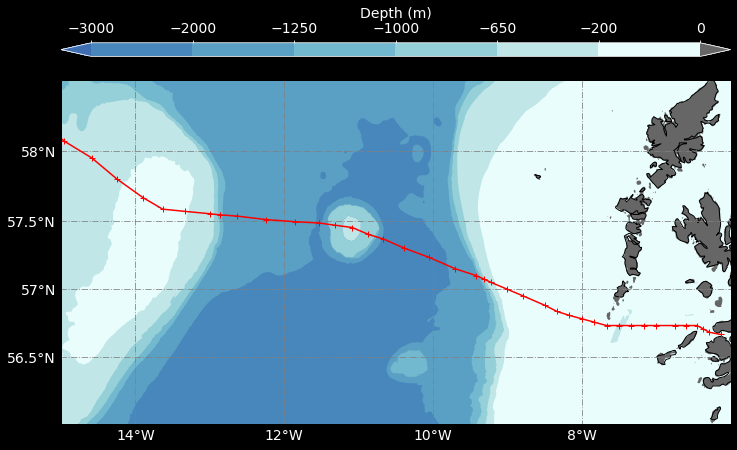

In [16]:
# Add an axes above the main axes.
axRT_divider = make_axes_locatable(axRT)

# Need to import matplotlib's axes class due to the projection used to generate ax2 and ax1
import matplotlib.axes as maxes

caxRT = axRT_divider.append_axes("top", size="4%", pad="7%", axes_class=maxes.Axes)
cb2 = fig.colorbar(cplot, cax=caxRT, orientation="horizontal")
# change tick position to top
caxRT.xaxis.set_ticks_position("top")
caxRT.xaxis.set_label_position("top")
caxRT.set_xlabel('Depth (m)')

fig

\
Iceland Basin area

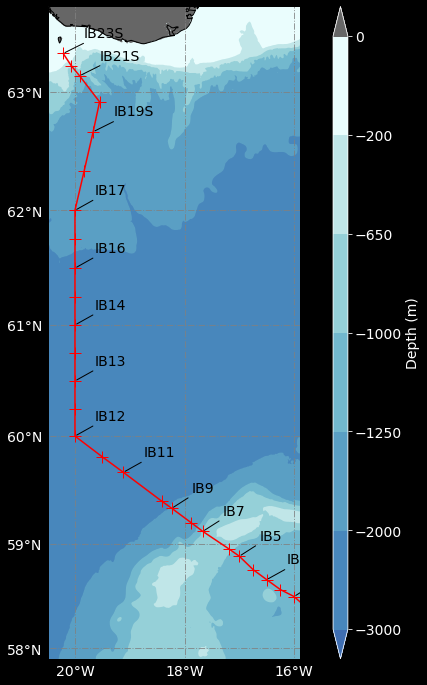

In [17]:
# Plot Map for IB
(fig,axIB,cplot)=plot_bathy_ENA(limits=[-20.5, -15.9, 57.9, 63.7],colorbar=True)
plot_gridlines(axIB,np.arange(-22,-12,2),np.arange(57,65,1))

# Add EEL station
axIB.plot(sdfloc['LonSta'], sdfloc['LatSta'],
         color='red', linestyle='-', marker='+', markersize=12, transform=ccrs.PlateCarree())



# Annotate Station labels
transform = ccrs.PlateCarree()._as_mpl_transform(axIB)
(mm,nn)=sdfloc.shape
colorano='black'
indexsta = sdfloc[sdfloc['LonSta']<-18].index.values
for iii in indexsta[::2]:
    axIB.annotate(sdfloc.loc[iii,'Staname'], # this is the text
                 (sdfloc.loc[iii,'LonSta'],sdfloc.loc[iii,'LatSta']), # this is the point to label
                 ha='left',
                 va='center',
                 color=colorano,
                 xytext=(20, 20), 
                 textcoords='offset points', 
                 arrowprops=dict(arrowstyle='-',
                                 color=colorano),
                 xycoords = transform) # horizontal alignment can be left, right or center

    
indexsta = sdfloc[(sdfloc['LonSta']>=-18) & (sdfloc['LonSta']<=-16)].index.values
for iii in indexsta[1::2]:
    axIB.annotate(sdfloc.loc[iii,'Staname'], # this is the text
                 (sdfloc.loc[iii,'LonSta'],sdfloc.loc[iii,'LatSta']), # this is the point to label
                 ha='left',
                 va='center',
                 color=colorano,
                 xytext=(20, 20), 
                 textcoords='offset points', 
                 arrowprops=dict(arrowstyle='-',
                                 color=colorano),
                 xycoords = transform) # horizontal alignment can be left, right or center



## TODO2: Produce other version of the figure with mean current ellipses at different depths (eg 100m, 800m, 2500m), perhaps with some representation of data coverage (eg dot size to indicate number of occupations of each station)

## Plot in a single file the main map and the zoomed map using subplots

Parameters definition

In [18]:
# general definitions
land = colorbrewer.get_map('Accent', 'qualitative', 8)
#ocean = colorbrewer.get_map('Blues', 'sequential', 6, reverse=True)
colors = np.array(ocean.mpl_colors[-6:])
levels = [-3000, -2000, -1250, -1000, -650, -200, 0]

colorano='black'

extent_map = [-28.1, 0.1, 51, 66]

central_lon, central_lat = -10, 45

zoombox1 = [-20.5, -15.9, 57.9, 63.7]
zoombox2 = [-18.1, -5.5, 56.4, 58.6]


\
Load additional libraries

In [19]:
from matplotlib.gridspec import GridSpec

import matplotlib.patches as mpatches


\
Plot main map and two "zoomed" boxes on a single figure

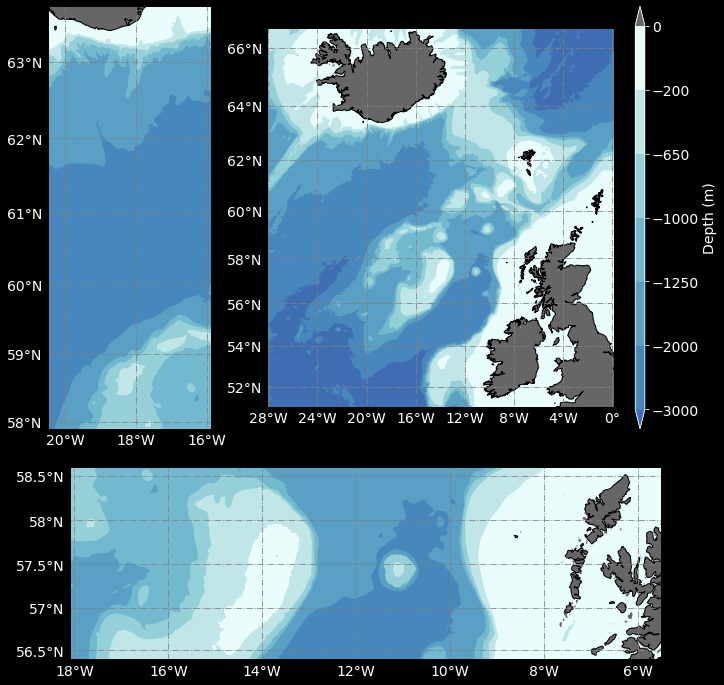

In [20]:
fig= plt.figure(figsize=(12, 12)) #, constrained_layout=True)
gs = GridSpec(nrows=3, ncols=3) # , width_ratios=[1,1, 3], height_ratios=[2,1,1])

#------------------------------------------------------------------------------------
# Define three panels on figure
# Main map
axmain = fig.add_subplot(gs[:-1, 1:],projection=ccrs.Mercator(central_lon, central_lat))
# Zoom Iceland Basin
axIB = fig.add_subplot(gs[:-1,0],projection=ccrs.Mercator(central_lon, central_lat))
# Zoom Rockall Trough
axRT = fig.add_subplot(gs[-1, :],projection=ccrs.Mercator(central_lon, central_lat))


#------------------------------------------------------------------------------------
# PLot map on each panel
plot_bathy_ENA(fig=fig,ax=axmain,limits=extent_map,gridlines=False)
plot_gridlines(axmain,np.arange(-28,4,4),np.arange(50,70,2))

plot_bathy_ENA(fig=fig,ax=axIB,limits=zoombox1,colorbar=False)
plot_gridlines(axIB,np.arange(-22,-12,2),np.arange(57,65,1))

plot_bathy_ENA(fig=fig,ax=axRT,limits=zoombox2,colorbar=False)
plot_gridlines(axRT,np.arange(-20,-2,2),np.arange(55.5,59.5,0.5))


\
Add extra plots on figure (EEL lines and rectangle on main map to indicate geographic limitations of zoomed maps)

In [21]:
# Add EEL Reference section on each plot 
for ax in [axmain,axIB,axRT]:
    ax.plot(sdfloc['LonSta'], sdfloc['LatSta'],
         color='red', linestyle='-', marker='+', transform=ccrs.PlateCarree())

#-------
# Add rectangle showing zoomed are on main map
# IB
rectzoom1 = [zoombox1[0], zoombox1[2], zoombox1[1]-zoombox1[0],zoombox1[3]-zoombox1[2]]
axmain.add_patch(mpatches.Rectangle(xy=rectzoom1[0:2], width=rectzoom1[2], height=rectzoom1[3], 
                                 alpha=1,
                                 fill=False,
                                 color='black',
                                 transform=ccrs.PlateCarree())
                )
     
# RT                 
rectzoom2 = [zoombox2[0], zoombox2[2], zoombox2[1]-zoombox2[0],zoombox2[3]-zoombox2[2]]
axmain.add_patch(mpatches.Rectangle(xy=rectzoom2[0:2], width=rectzoom2[2], height=rectzoom2[3], 
                                 alpha=1,
                                 fill=False,
                                 color='black',
                                 transform=ccrs.PlateCarree())
                )
                 

\
Annotate EEL stations

In [22]:
## ANNOTATE STATIONS
#------------------------------------------------------------------------------------
# IB Box

transform = ccrs.PlateCarree()._as_mpl_transform(axIB)
(mm,nn)=sdfloc.shape

# Display station name top right of section for station west of -18W
indexsta = sdfloc[sdfloc['LonSta']<-18].index.values
for iii in indexsta[::2]:
    axIB.annotate(sdfloc.loc[iii,'Staname'], # this is the text
                 (sdfloc.loc[iii,'LonSta'],sdfloc.loc[iii,'LatSta']), # this is the point to label
                 ha='left',
                 va='center',
                 color=colorano,
                 xytext=(20, 0o0), 
                 textcoords='offset points', 
                 arrowprops=dict(arrowstyle='-',
                                 color=colorano),
                 xycoords = transform) # horizontal alignment can be left, right or center

# Display station name bottom left of section for station located between -18W and 16W
indexsta = sdfloc[(sdfloc['LonSta']>=-18) & (sdfloc['LonSta']<=-16)].index.values
for iii in indexsta[1::2]:
    axIB.annotate(sdfloc.loc[iii,'Staname'], # this is the text
                 (sdfloc.loc[iii,'LonSta'],sdfloc.loc[iii,'LatSta']), # this is the point to label
                 ha='right',
                 va='center',
                 color=colorano,
                 xytext=(-20, 0o0), 
                 textcoords='offset points', 
                 arrowprops=dict(arrowstyle='-',
                                 color=colorano),
                 xycoords = transform) # horizontal alignment can be left, right or center
    
#------------------------------------------------------------------------------------
# RT Box

transform = ccrs.PlateCarree()._as_mpl_transform(axRT)

# Display station name bottom left of section for station located between -16W and 13.6W
indexsta = sdfloc[(sdfloc['LonSta']>=-16) & (sdfloc['LonSta']<=-13.6)].index.values
for iii in indexsta[::2]:
    axRT.annotate(sdfloc.loc[iii,'Staname'], # this is the text
                 (sdfloc.loc[iii,'LonSta'],sdfloc.loc[iii,'LatSta']), # this is the point to label
                 ha='right',
                 va='center',
                 color=colorano,
                 xytext=(-20, -20), 
                 textcoords='offset points', 
                 arrowprops=dict(arrowstyle='-',
                                 color=colorano),
                 xycoords = transform) # horizontal alignment can be left, right or center

# Display station name top right of section for station located east of 13.6W
indexsta = sdfloc[sdfloc['LonSta']>-13.6].index.values
for iii in indexsta[1::2]:
    axRT.annotate(sdfloc.loc[iii,'Staname'], # this is the text
                 (sdfloc.loc[iii,'LonSta'],sdfloc.loc[iii,'LatSta']), # this is the point to label
                 ha='right',
                 va='center',
                 color=colorano,
                 xytext=(-20, -20), 
                 textcoords='offset points', 
                 arrowprops=dict(arrowstyle='-',
                                 color=colorano),
                 xycoords = transform) # horizontal alignment can be left, right or center
    

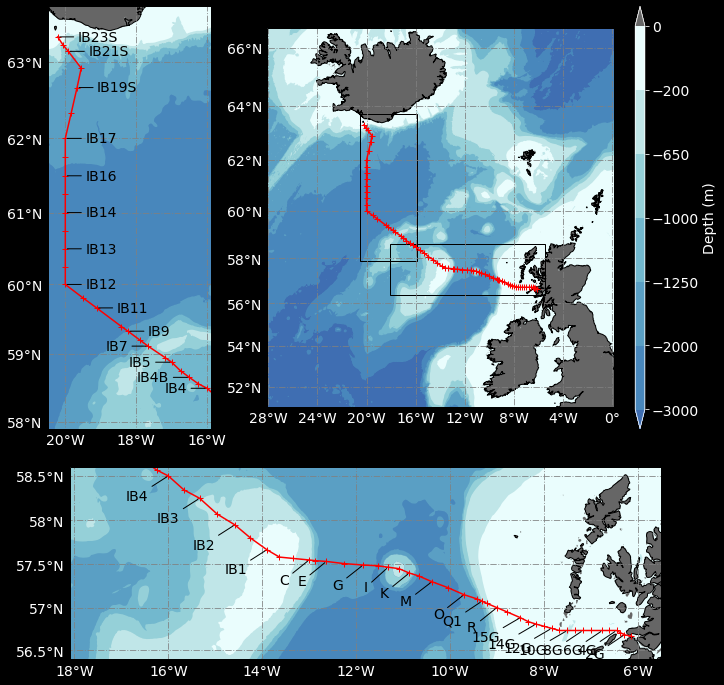

In [23]:
fig

In [24]:
# Save Figure
fig.savefig('figures/'+'01_Map_Eastern_NA_allinone.pdf')   

\
Final labels will be edited in Inkscape, particularly east of the section (east of 15G)